In [5]:
import pandas as pd
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [43]:
!pip install opendatasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 8.1 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102971 sha256=664bbc60ce41e3190611389e8a16ea0b61466213a60874014ebeab5b489c492d
  Stored in directory: /Users/avantikagarg/Library/Caches/pip/wheels/f3/eb/e9/819c2d9eac90204eec8579430759f75a1d6dbe4cd0b93f53bc
Successfully built kaggle


In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/trungit/wikiart25k'
od.download(dataset_url)

In [7]:
# Load dataset
df = pd.read_csv('valid_images.csv')

In [8]:
def get_image_path(art_style, painting, top_dir='../../acv_project/archive'):
    path = f"{top_dir}/{art_style}/{painting}.jpg"
    return path

In [9]:
print(df.iloc[1])

art_style                                         Impressionism
painting                          willard-metcalf_havana-harbor
emotion                                             contentment
utterance     The red of the flowers pop off the page, it is...
repetition                                                    7
Name: 1, dtype: object


In [10]:
class CaptionDataset(Dataset):
    def __init__(self,df, tokenizer, transform=None):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = get_image_path(self.df.iloc[idx]['art_style'], self.df.iloc[idx]['painting'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        caption = self.df.iloc[idx]['utterance']

        return {'image': image, 'caption': caption}

In [11]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [32]:
def collate_fn(batch):
    images = [item['image'] for item in batch]
    images_stacked = torch.stack(images)

    captions = [item['caption'] for item in batch]
    captions_tokenized = tokenizer(
        captions,
        padding=True,
        return_tensors='pt'
    )

    return {'images': images_stacked, 'captions': captions_tokenized['input_ids']}

In [34]:
# Separate the dataset into training, testing, and validation sets

train_df, test_df = train_test_split(df, test_size=0.2)

Text(0.5, 1.0, 'Image 3')

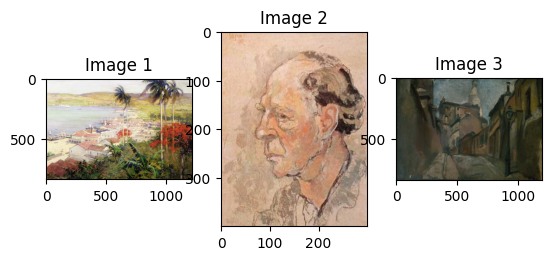

In [35]:
# Display 3 randomly chosen images using matplotlib.  Consider the colormap so

image1 = Image.open(get_image_path(df.iloc[0]['art_style'], df.iloc[0]['painting'])).convert('RGB')
image2 = Image.open(get_image_path(df.iloc[10]['art_style'], df.iloc[10]['painting'])).convert('RGB')
image3 = Image.open(get_image_path(df.iloc[200]['art_style'], df.iloc[200]['painting'])).convert('RGB')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(image1, cmap='gray')
ax1.set_title('Image 1')
ax2.imshow(image2, cmap='gray')
ax2.set_title('Image 2')
ax3.imshow(image3, cmap='gray')
ax3.set_title('Image 3')

In [36]:
# transforms because the images are not the same size

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [37]:
# creating the dataset and dataloader

train_dataset = CaptionDataset(train_df, tokenizer, transform)
test_dataset = CaptionDataset(test_df, tokenizer, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [18]:
# Using CNN to extract features from images (ResNet)
# Using LSTM to generate captions

import torch
import torch.nn as nn
from torchvision.models import resnet50
from transformers import BertModel, BertConfig

In [38]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers):
        super(ImageCaptioningModel, self).__init__()

        # load pretrained resnet model
        resnet = resnet50(pretrained=True)

        # freeze the resnet layers so that they are not trained
        for param in resnet.parameters():
            param.requires_grad = False

        # remove the classification layer and replace it with a linear layer
        # this reduces the output dimension to match the embedding dimension
        resnet.fc = nn.Linear(resnet.fc.in_features, embed_dim)
        self.cnn = resnet

        # LSTM for generating captions
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)

        # output layer that maps the hidden state output dimension to the vocab size
        # this helps to predict the next word in the caption 
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, images, captions):

        # extract features from images
        features = self.cnn(images)

        # unsqueeze the dimensions of the features tensor
        # repeat it so that the same features are used for each word in the caption
        features = features.unsqueeze(1).repeat(1, captions.size(1), 1)

        # get output from the LSTM
        # a new hidden state is generated for each word in the caption
        lstm_output, _ = self.lstm(features)

        # linear layer takes output and predicts the next word in the caption
        outputs = self.linear(lstm_output)

        return outputs

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
image_to_caption_model = ImageCaptioningModel(embed_dim=256, hidden_dim=512, vocab_size=len(tokenizer.vocab), num_layers=1)
model =image_to_caption_model.to(device)

/Users/avantikagarg/Documents/Applied_cv/acv_project/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/avantikagarg/Documents/Applied_cv/acv_project/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
model.train()
for epoch in range(5):
    for batch in train_loader:
        images = batch['images'].to(device)
        captions = batch['captions'].to(device)

        # excluding the last word in the caption (<end> token)
        print(f"Captions shape: {captions.shape}")

        outputs = model(images, captions[:, :-1])
        
        print(f"Outputs shape: {outputs.shape}")


        # offset the caption by one to the right (exclude the <start> token)
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch}, Loss: {loss.item()}')

Captions shape: torch.Size([32, 27])
Outputs shape: torch.Size([32, 26, 30522])
Captions shape: torch.Size([32, 55])
Outputs shape: torch.Size([32, 54, 30522])
Captions shape: torch.Size([32, 56])
Outputs shape: torch.Size([32, 55, 30522])
Captions shape: torch.Size([32, 31])
Outputs shape: torch.Size([32, 30, 30522])
Captions shape: torch.Size([32, 58])
Outputs shape: torch.Size([32, 57, 30522])
Captions shape: torch.Size([32, 42])
Outputs shape: torch.Size([32, 41, 30522])
Captions shape: torch.Size([32, 47])
Outputs shape: torch.Size([32, 46, 30522])
Captions shape: torch.Size([32, 31])
Outputs shape: torch.Size([32, 30, 30522])
Captions shape: torch.Size([32, 44])
Outputs shape: torch.Size([32, 43, 30522])
Captions shape: torch.Size([32, 106])
Outputs shape: torch.Size([32, 105, 30522])
Captions shape: torch.Size([32, 60])
Outputs shape: torch.Size([32, 59, 30522])
Captions shape: torch.Size([32, 45])
Outputs shape: torch.Size([32, 44, 30522])
Captions shape: torch.Size([32, 37])
O

KeyboardInterrupt: 

In [ ]:
# save the model
torch.save(model.state_dict(), 'image_captioning_model.pth')